# Primary analysis

Study title: Increased normalized lactate load is associated with higher mortality in both sepsis and non-sepsis patients: an analysis of the MIMIC-IV database

DOI: https://doi.org/10.1186/s12871-022-01617-5

This notebook provides insights into the data analyzed for the given study.

The objective of the study was: To evaluate the association between normalized lactate load, an index that incorporates the magnitude of change and the time interval of such evolution of lactate, and 28-day mortality in sepsis and non-sepsis patients.

## Import libraries

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from tableone import TableOne
from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore')

Next we load in the generated tables.

In [2]:
data_path = Path(f'../data/')
os.chdir(data_path)

cohort = pd.read_csv('cohort.csv')
comorbidities = pd.read_csv('comorbidities.csv')
labs = pd.read_csv('labs.csv')
lactate = pd.read_csv('lactate.csv')
lactateload = pd.read_csv('lactateload.csv')
main = pd.read_csv('main.csv')
mortality = pd.read_csv('mortality.csv')
vitalsigns = pd.read_csv('vitalsigns.csv')

## Exclusions


Apply exclusions. Below function may be useful in printing out exclusions.

In [3]:
def get_exclusions(df, verbose=True):
    """
    Get all exclusions, assuming columns begin with the word exclusion.
    
    Returns an index of stays to *keep* in the study.
    """
    N = df.shape[0]
    idx = df.index.notnull()
    cols = [c for c in df.columns if c.startswith('exclusion')]

    if verbose:
        print(f'{N} stays')

    # remove excluded patients
    for c in cols:
        idxExcl = df[c] == 1
        n_excl = (idx & idxExcl).sum()
        frac = n_excl / N * 100.0
        if verbose:
            print(f'  {n_excl:5d} / {N:5d} ({frac:3.1f}%) - {c}')
        idx = idx & ~idxExcl
        N = idx.sum()
    
    return idx

## Preprocess

Process and merge dataframes into a final study dataframe.

In [4]:
idx = get_exclusions(cohort)
# create a "co" dataframe with only the hadm_id we intend to keep
co = cohort.loc[idx, ['subject_id','hadm_id','stay_id', 'sepsis']].copy().reset_index(drop=True)

# Calculate lactate load and normalized lactate load
ll = lactateload.groupby('stay_id') 
lactate_load = []
normalized_lactate_load = []
stay_id = []

for group, item in ll:
  _sum = 0
  for v1, v2, n1, n2, t1, t2 in zip(ll.get_group(group)['lactate'], ll.get_group(group)['lactate'][1:], ll.get_group(group)['n'],
                                    ll.get_group(group)['n'][1:], ll.get_group(group)['time'], ll.get_group(group)['time'][1:]):
    if n1 == 1:
      _sum += (((v1+v1)/2)*(t1-0))
    if n2 == ll.get_group(group)['n'].iloc[-1]:
      _sum += (((v2+v2)/2)*(24-t2))
    _sum += (((v1+v2)/2)*(t2-t1))
    
  stay_id.append(group)
  lactate_load.append(_sum)
  normalized_lactate_load.append(_sum/24)

new_lactate_load = pd.DataFrame({'stay_id': stay_id, 'lactate_load': lactate_load, 'normalized_lactate_load': normalized_lactate_load})

# Merge all the dataframes into one
df = pd.merge(co, main, how='left', on=['subject_id','hadm_id','stay_id']) \
       .merge(mortality, how='left', on=['subject_id','hadm_id']) \
       .merge(comorbidities, how='left', on=['subject_id','hadm_id']) \
       .merge(labs, how='left', on=['subject_id','hadm_id','stay_id']) \
       .merge(vitalsigns, how='left', on=['subject_id','hadm_id','stay_id']) \
       .merge(lactate, how='left', on=['subject_id','hadm_id','stay_id']) \
       .merge(new_lactate_load, how='left', on='stay_id')

# remove the identifiers to simplify analysis
data = df.loc[:, ~df.columns.isin(['subject_id','hadm_id','stay_id'])]

# remove outliers and implausible values
data['weight'] = np.where(data['weight'] < 10, np.nan, data['weight'])
data['daily_urine_output'] = np.where( (data['daily_urine_output'] < 10) | (data['daily_urine_output'] > 20000), np.nan, data['daily_urine_output'])
data['min_systolic_bp'] = np.where(data['min_systolic_bp'] < 5, np.nan, data['min_systolic_bp'])
data['min_diastolic_bp'] = np.where(data['min_diastolic_bp'] < 5, np.nan, data['min_diastolic_bp'])
data['min_mean_arterial_bp'] = np.where(data['min_mean_arterial_bp'] < 5, np.nan, data['min_mean_arterial_bp'])
data['max_respiratory_rate'] = np.where(data['max_respiratory_rate'] > 1000, np.nan, data['max_respiratory_rate'])


39642 stays
      0 / 39642 (0.0%) - exclusion_non_adult
   8435 / 39642 (21.3%) - exclusion_readmission
  12294 / 31207 (39.4%) - exclusion_one_lactate_measurement
   1487 / 18913 (7.9%) - exclusion_short_icu_stay


## Analyze

Apply the analysis method.

The authors constructed ROC curves to test the performance of maximum lactate, mean lactate, and normalized lactate load. They did not mention which machine learning model was used in their paper so for the purposes of simplicity I will use logistic regression. 


In [5]:
# Calculate AUC using Logistic Regression
def get_auc(X, y):

    model = LogisticRegression()
    model.fit(X, y)

    y_prob = model.predict_proba(X)[:, 1]
    auc = round(roc_auc_score(y, y_prob),3)
    print(f'AUC: {auc}')
    
    return auc

# Normalized lactate load: all patients
auc_norm1 = get_auc(data[['normalized_lactate_load']], data[['died_in_28_days']])

# Maximum lactate: all patients
auc_max1 = get_auc(data[['max_lactate']], data[['died_in_28_days']])

# Mean lactate: all patients
auc_mean1 = get_auc(data[['mean_lactate']], data[['died_in_28_days']])

# Normalized lactate load: sepsis patients
auc_norm2 = get_auc(data[['normalized_lactate_load']][data['sepsis']==1], data[['died_in_28_days']][data['sepsis']==1])

# Maximum lactate: sepsis patients
auc_max2 = get_auc(data[['max_lactate']][data['sepsis']==1], data[['died_in_28_days']][data['sepsis']==1])

# Mean lactate: sepsis patients
auc_mean2 = get_auc(data[['mean_lactate']][data['sepsis']==1], data[['died_in_28_days']][data['sepsis']==1])

# Normalized lactate load: non-sepsis patients
auc_norm3 = get_auc(data[['normalized_lactate_load']][data['sepsis']==0], data[['died_in_28_days']][data['sepsis']==0])

# Maximum lactate: non-sepsis patients
auc_max3 = get_auc(data[['max_lactate']][data['sepsis']==0], data[['died_in_28_days']][data['sepsis']==0])

# Mean lactate: non-sepsis patients
auc_mean3 = get_auc(data[['mean_lactate']][data['sepsis']==0], data[['died_in_28_days']][data['sepsis']==0])


AUC: 0.661
AUC: 0.633
AUC: 0.649
AUC: 0.663
AUC: 0.638
AUC: 0.653
AUC: 0.653
AUC: 0.625
AUC: 0.64


## Results

Print tables / figures / statements summarizing the results in a similar manner to the original study.

In [6]:
# Table 1: Comparisons of the baseline clinical characteristics between sepsis and non-sepsis
pd.set_option('display.max_rows', None)

categorical = ['gender','died_in_28_days','congestive_heart_failure','myocardial_infarction','cerebrovascular_disease','chronic_pulmonary_disease',
               'mild_liver_disease','severe_liver_disease','diabetes_without_complication','diabetes_with_complication','renal_disease']

groupby = 'sepsis'

nonnormal = ['length_of_hospital_stay','length_of_icu_stay','daily_urine_output','max_bilirubin','max_lactate','mean_lactate','lactate_load','normalized_lactate_load']

TableOne(data, categorical=categorical, groupby=groupby, nonnormal=nonnormal, pval=True)

Grouped by sepsis                                                                              
                                                      Missing                Overall                       0                      1 P-Value
n                                                                              17426                   11544                   5882        
age, mean (SD)                                              0            64.0 (15.9)             63.5 (15.8)            65.1 (15.9)  <0.001
gender, n (%)                           F                   0            6865 (39.4)             4298 (37.2)            2567 (43.6)  <0.001
                                        M                               10561 (60.6)             7246 (62.8)            3315 (56.4)        
weight, mean (SD)                                         534            83.7 (23.7)             84.3 (22.8)            82.6 (25.2)  <0.001
sofa_score, mean (SD)                                       0              7.2 (4.0)               6.7 (3.9)              8.3 (3.9)  <0.001
sapsii_score, mean (SD)                                     0            41.1 (14.7)             39.6 (14.5)            44.0 (14.8)  <0.001
length_of_hospital_stay, median [Q1,Q3]                     0         9.0 [5.0,15.0]          9.0 [5.0,14.0]         9.0 [6.0,16.0]  <0.001
length_of_icu_stay, median [Q1,Q3]                          0          3.0 [2.0,6.0]           3.0 [1.0,5.0]          3.0 [2.0,6.0]  <0.001
daily_urine_output, median [Q1,Q3]                        376  1555.0 [960.2,2360.0]  1630.0 [1050.0,2410.0]  1400.0 [800.0,2215.0]  <0.001
died_in_28_days, n (%)                  0                   0           14942 (85.7)            10182 (88.2)            4760 (80.9)  <0.001
                                        1                                2484 (14.3)             1362 (11.8)            1122 (19.1)        
congestive_heart_failure, n (%)         0.0                10           12680 (72.8)             8480 (73.5)            4200 (71.5)   0.005
                                        1.0                              4736 (27.2)             3060 (26.5)            1676 (28.5)        
myocardial_infarction, n (%)            0.0                10           14371 (82.5)             9359 (81.1)            5012 (85.3)  <0.001
                                        1.0                              3045 (17.5)             2181 (18.9)             864 (14.7)        
cerebrovascular_disease, n (%)          0.0                10           17071 (98.0)            11352 (98.4)            5719 (97.3)  <0.001
                                        1.0                                345 (2.0)               188 (1.6)              157 (2.7)        
chronic_pulmonary_disease, n (%)        0.0                10           16380 (94.1)            10908 (94.5)            5472 (93.1)  <0.001
                                        1.0                               1036 (5.9)               632 (5.5)              404 (6.9)        
mild_liver_disease, n (%)               0.0                10           17144 (98.4)            11384 (98.6)            5760 (98.0)   0.002
                                        1.0                                272 (1.6)               156 (1.4)              116 (2.0)        
severe_liver_disease, n (%)             0.0                10           17364 (99.7)            11507 (99.7)            5857 (99.7)   0.779
                                        1.0                                 52 (0.3)                33 (0.3)               19 (0.3)        
diabetes_without_complication, n (%)    0.0                10           14286 (82.0)             9466 (82.0)            4820 (82.0)   1.000
                                        1.0                              3130 (18.0)             2074 (18.0)            1056 (18.0)        
diabetes_with_complication, n (%)       0.0                10           17314 (99.4)            11474 (99.4)            5840

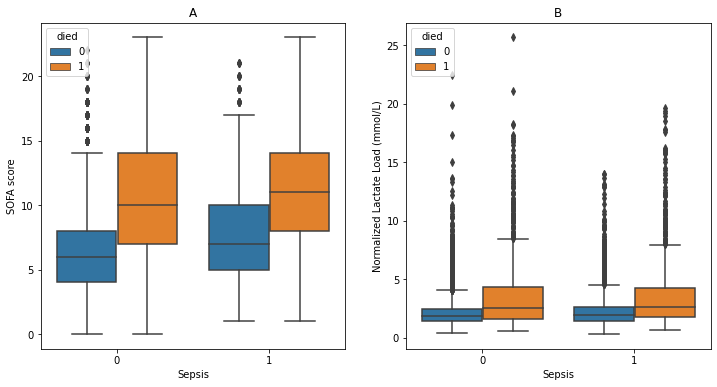

In [7]:
# Figure 3: Severity score and normalized lactate load in sepsis and non-sepsis patients

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

plot = sns.boxplot(x='sepsis', y='sofa_score', hue='died_in_28_days', data=data)
plot.set(xlabel = 'Sepsis', ylabel='SOFA score', title='A')
plot.legend(title='died', loc='upper left')

plt.subplot(1, 2, 2)
plot2 = sns.boxplot(x='sepsis', y='normalized_lactate_load', hue='died_in_28_days', data=data)
plot2.set(xlabel = 'Sepsis', ylabel='Normalized Lactate Load (mmol/L)', title='B')
plot2.legend(title='died', loc='upper left')

Severity score and normalized lactate load in sepsis and non-sepsis patients. Panel A: Sepsis patients had significantly higher sequential organ failure assessment (SOFA) scores than non-sepsis patients, while non-survivors had significantly higher SOFA scores than survivors in each group. Panel B: Similarly, sepsis patients had significantly higher normalized lactate load than non-sepsis patients, while non-survivors had significantly higher normalized lactate load than survivors in each group

In [8]:
# Table 2: Performance of normalized lactate load, maximum lactate, and mean lactate in predicting 28-day mortality

table = [[' ','All Patients', 'Sepsis Patients', 'Non-Sepsis Patients'], ['Normalized Lactate Load', auc_norm1, auc_norm2, auc_norm3], 
         ['Maximum Lactate', auc_max1, auc_max2, auc_max3], ['Mean Lactate', auc_mean1, auc_mean2, auc_mean3]]

print(tabulate(table, tablefmt='fancy_grid'))

╒═════════════════════════╤══════════════╤═════════════════╤═════════════════════╕
│                         │ All Patients │ Sepsis Patients │ Non-Sepsis Patients │
├─────────────────────────┼──────────────┼─────────────────┼─────────────────────┤
│ Normalized Lactate Load │ 0.661        │ 0.663           │ 0.653               │
├─────────────────────────┼──────────────┼─────────────────┼─────────────────────┤
│ Maximum Lactate         │ 0.633        │ 0.638           │ 0.625               │
├─────────────────────────┼──────────────┼─────────────────┼─────────────────────┤
│ Mean Lactate            │ 0.649        │ 0.653           │ 0.64                │
╘═════════════════════════╧══════════════╧═════════════════╧═════════════════════╛


According to the authors, the AUCs of maximum lactate, mean lactate and normalized lactate load were significantly greater in sepsis patients than in non-sepsis patients. This can be seen in the above table, however without confidence intervals I cannot make that same conclusion. 